# Assoziaionsanlayse

Untersucht wird nur der Datensatz der Rotweine (~1600 Zeilen).
Der Datensatz der Weißweine ist zu groß (~5000 Zielen).

## Setup

In [89]:
# Setup
from mlxtend.frequent_patterns import apriori, association_rules
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.plotting

In [90]:
# Einelsen der Daten
df_red = pd.read_csv('winequality-red-filtered.csv', sep=';', header=0) 
df_white = pd.read_csv('winequality-white-filtered.csv', sep=';', header=0) 

## Scatter-Plots

In [91]:
def scatter(df, columns):
    pd.plotting.scatter_matrix(df[columns],
        figsize=(15, 15),
        marker="o",
        c=df['quality'].values,
        s=30,
        alpha=0.8,
    )
    plt.show()

### Säureanteile - PH-Wert

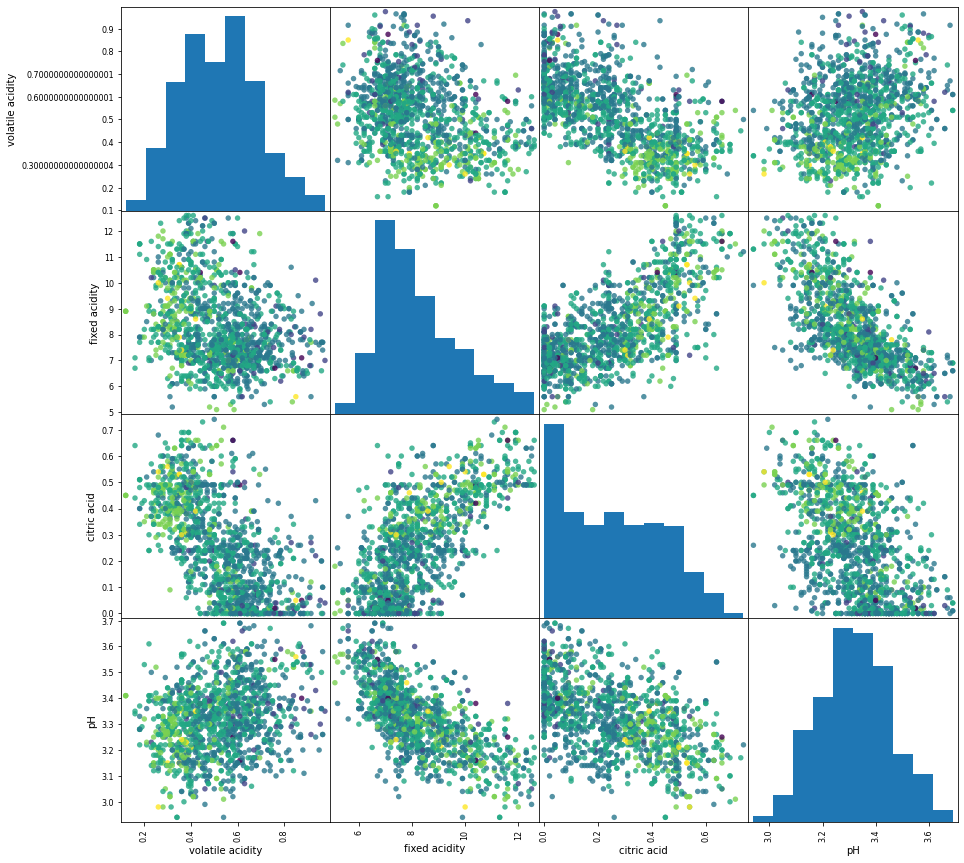

In [92]:
scatter(df_red, ["volatile acidity", "fixed acidity","citric acid","pH"])

### Säureanteile - Alkohol - Dichte

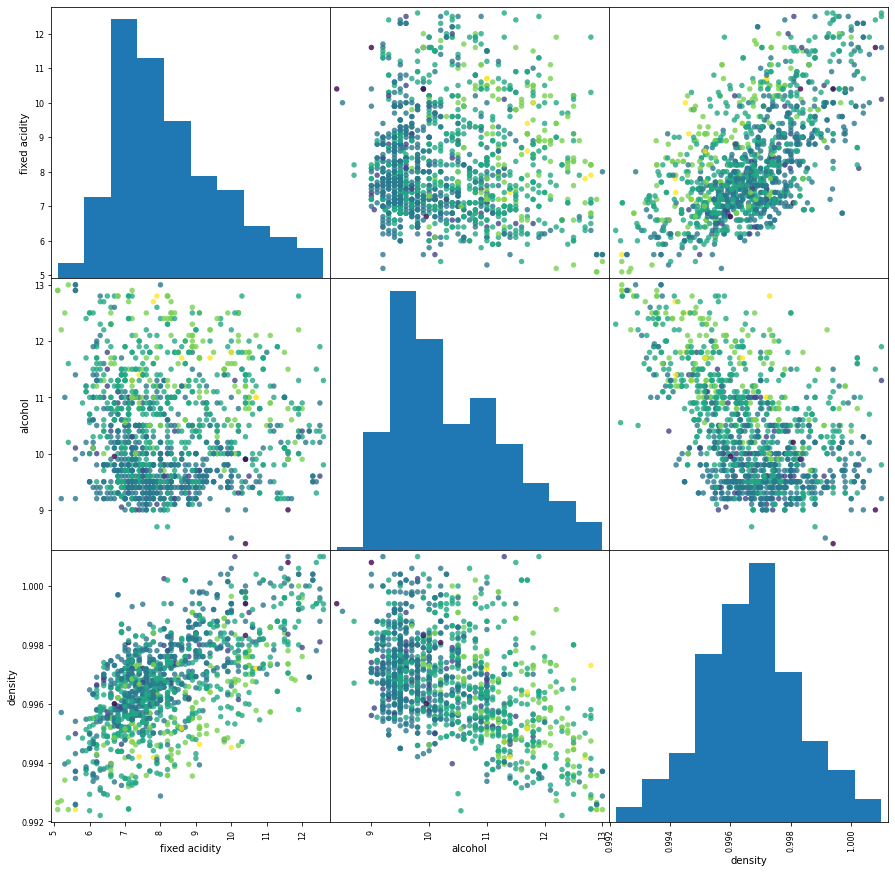

In [93]:
scatter(df_red, ["fixed acidity","alcohol","density"])

### Schwefeloxide - freie Schwefeloxide

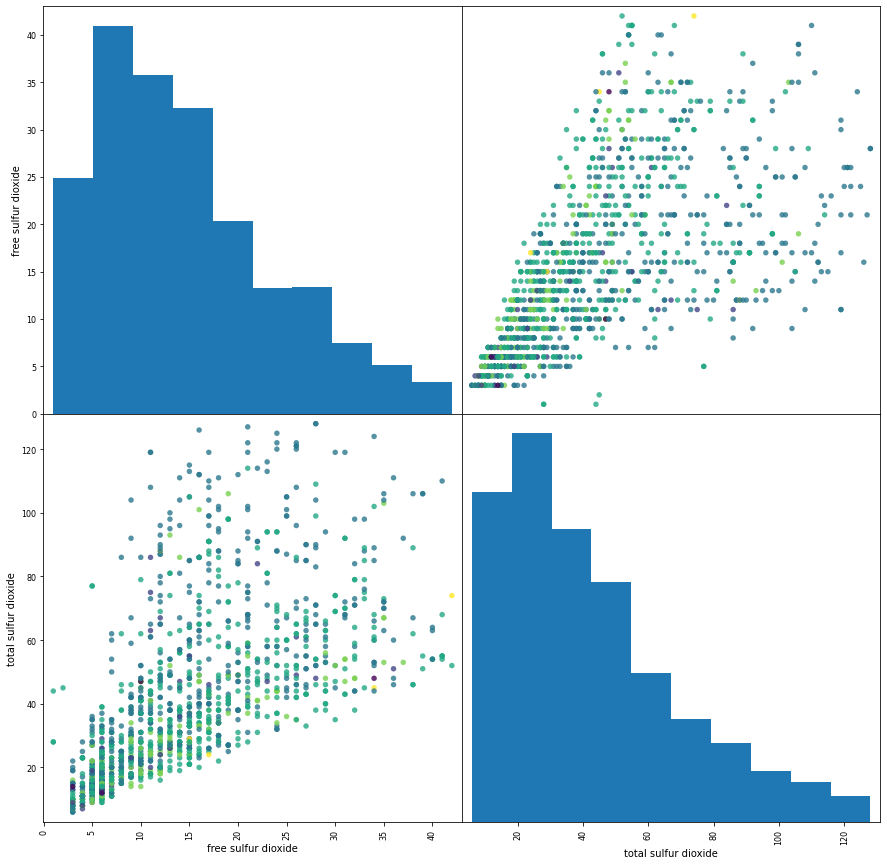

In [94]:
scatter(df_red, ["free sulfur dioxide","total sulfur dioxide"])

### Flüchtige Säureanteile - Alkohol - Qualität

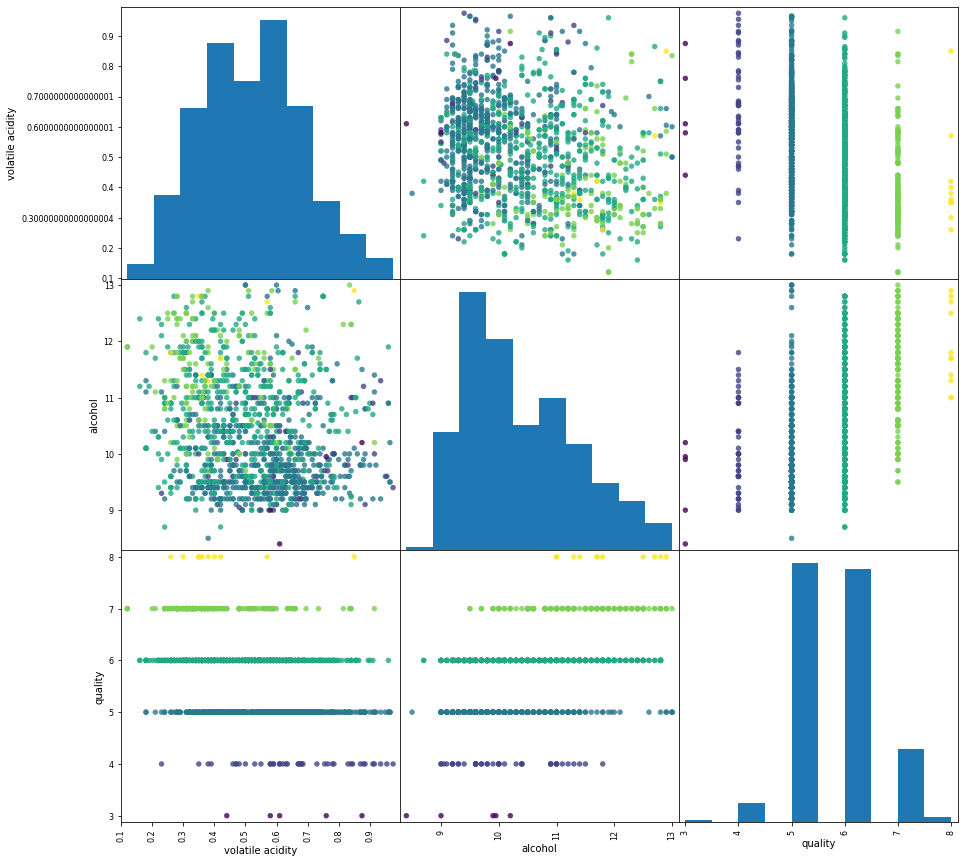

In [95]:
scatter(df_red, ["volatile acidity","alcohol","quality"])

## Einteilung in Klassen
Um Support, Konfidenz und Lift verschiedener Ereignisse zu berechnen, werden die kontinuierlichen Daten diskretisiert.

In [ ]:
# Einteilung in je 3 Klassen (unter 25%, 25-75%, ueber 75% Quantil)
# Erstellung einer binäre Matrix für apriori
df = pd.DataFrame()
for c in df_red.columns:
    q_25 = df_red[c].quantile(q=0.25)
    q_75 = df_red[c].quantile(q=0.75)
    print(f'{c}:  {q_25}  {q_75}')
    df[f'{c}_low'] = df_red[c].le(q_25).astype(int)
    df[f'{c}_mid'] = df_red[c].between(q_25, q_75, inclusive='right').astype(int)
    df[f'{c}_high'] = df_red[c].gt(q_75).astype(int)

In [96]:
# Vollständig Ausgabe von Dataframes ohne Zeilenumbrüche
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

### Konfidenz

In [97]:
"""
Ergebnisse mit hoher Konfidenz:
- Zusammenhang freier Schwefelanteil und Gesamtschwefelanteil
- Zusammenhang feste Säureanteile und Citronensäure
- Zusammenhang pH-Wert und Säureanteil
- Zusammenhang Alkohl und Dichte
==> chemische Zusammenhänge bestätigt

- Wenig Alkohol -> mindere Qualität
- Wenig Sulfate -> mindere Qualität
- Viel Schwefel -> mindere Qualität (Schwefel ist Haltbarkeitsmittel mit schlechtem Geschmack, mehr nötig bei faulen Trauben)
- Hoher Anteil flüchtiger Säuren -> mindere Qualität
==> Indikatoren für schlechten Wein
"""
# Auch mit max_len=3 getestet
analysis = apriori(df, min_support=0.05, use_colnames=True, max_len=2)
rules = association_rules(analysis, min_threshold=0.00)
rules.sort_values(by="confidence", ascending=False, inplace=True)
#print(rules)
print(rules.loc[[695,694,727,726]])
print("\n")
print(rules.loc[[120,121]])
print("\n")
print(rules.loc[[33,145]])
print("\n")
print(rules.loc[[880]])
print("\n")
print(rules.loc[[1005,980,314,864]])

                    antecedents                 consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
695  (total sulfur dioxide_low)   (free sulfur dioxide_low)            0.253553            0.255797  0.192221    0.758112  2.963731  0.127363    3.076646
694   (free sulfur dioxide_low)  (total sulfur dioxide_low)            0.255797            0.253553  0.192221    0.751462  2.963731  0.127363    3.003353
727   (free sulfur dioxide_mid)  (total sulfur dioxide_mid)            0.497382            0.498130  0.328347    0.660150  1.325257  0.080586    1.476741
726  (total sulfur dioxide_mid)   (free sulfur dioxide_mid)            0.498130            0.497382  0.328347    0.659159  1.325257  0.080586    1.474641


              antecedents           consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
120  (fixed acidity_high)    (citric acid_high)            0.242334            0.24981

### Lift

In [98]:
"""
Ergebnisse mit hohem Lift, aber teils geringer Konfidenz:
- Hoher Alkoholgehalt -> hohe Qualität
- Wenig flüchtige Säuren -> hohe Qualität
- Viele Sulfate -> hohe Qualität
- Viel Citronensäure -> hohe Qualität
==> nur bedingt Indikatoren für guten Wein
"""
analysis = apriori(df, min_support=0.05, use_colnames=True, max_len=2)
rules = association_rules(analysis, min_threshold=0.00)
rules.sort_values(by="lift", ascending=False, inplace=True)
#print(rules)
print(rules.loc[[1014, 210, 1002, 886]])

                 antecedents     consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
1014          (alcohol_high)  (quality_high)            0.241586             0.12715  0.081526    0.337461  2.654034  0.050808    1.317432
210   (volatile acidity_low)  (quality_high)            0.255797             0.12715  0.074046    0.289474  2.276625  0.041522    1.228455
1002        (sulphates_high)  (quality_high)            0.246073             0.12715  0.071055    0.288754  2.270964  0.039766    1.227212
886            (density_low)  (quality_high)            0.256545             0.12715  0.062827    0.244898  1.926050  0.030208    1.155936


In [99]:
"""
Ergebnisse mit Lift nahe 1: Eigenschaften, die keine Einfluss darauf haben ob Wein schlecht ist
- niedriger pH-Wert
- niedriger/hoher Restzucker
- viel freies Schwefeldioxid
"""
analysis = apriori(df, min_support=0.05, use_colnames=True, max_len=2)
rules = association_rules(analysis, min_threshold=0.00)
rules = rules[rules.lift.between(0.95,1.05)]
rules = rules[rules.consequents.apply(lambda c: bool(c.intersection({"quality_low","quality_mid","quality_high"})))]
rules.sort_values(by="lift", ascending=True, inplace=True)
#print(rules)
print(rules.loc[[938, 580, 492, 786]])

                    antecedents    consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
938                    (pH_low)  (quality_low)            0.253553            0.458489  0.113687    0.448378  0.977946 -0.002564    0.981669
580       (residual sugar_high)  (quality_low)            0.243082            0.458489  0.115931    0.476923  1.040206  0.004481    1.035241
492        (residual sugar_low)  (quality_low)            0.298429            0.458489  0.142857    0.478697  1.044074  0.006031    1.038764
786  (free sulfur dioxide_high)  (quality_low)            0.246821            0.458489  0.118175    0.478788  1.044273  0.005010    1.038945


In [100]:
"""
Ergebnisse mit geringem Lift
- wenig freie sauere -> unwahrscheinlicher dass wein schlecht
- viele sulfate -> unwahrscheinlicher dass wein schlecht

2 Klassen (und max_len=2)
- wenig alk -> guter wein unwahrscheinlicher
- und viel mehr
"""
analysis = apriori(df, min_support=0.05, use_colnames=True, max_len=2)
rules = association_rules(analysis, min_threshold=0.00)
rules = rules[rules.consequents.apply(lambda c: bool(c.intersection({"quality_low","quality_mid","quality_high"})))]
rules.sort_values(by="lift", ascending=True, inplace=True)
#print(rules)
print(rules.loc[[998,206,882]])

                antecedents    consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
998        (sulphates_high)  (quality_low)            0.246073            0.458489  0.053852    0.218845  0.477318 -0.058970    0.693218
206  (volatile acidity_low)  (quality_low)            0.255797            0.458489  0.061331    0.239766  0.522948 -0.055949    0.712295
882           (density_low)  (quality_low)            0.256545            0.458489  0.069559    0.271137  0.591371 -0.048064    0.742953
